# Data Preprocessing


## Library import


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [4]:
warnings.filterwarnings('ignore')

In [5]:
col_pal = sns.color_palette()

## Data import


In [7]:
df = pd.read_csv('./DATA/PJME_hourly.csv')

## EDA(exploratory data analysis)


In [9]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [10]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


**The data from 2002-2018 was stored in this dataframe**

In [12]:
df.dtypes

Datetime     object
PJME_MW     float64
dtype: object

In [13]:
df.shape

(145366, 2)

In [14]:
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [15]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


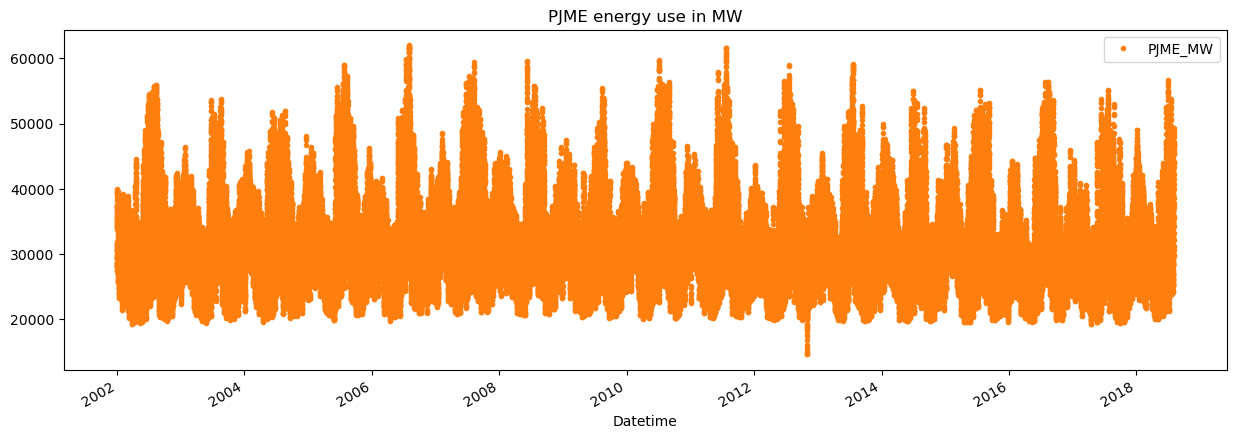

In [16]:
df.plot(style = '.',
        figsize = (15,5),
        color = col_pal[1],
        title = 'PJME energy use in MW')
plt.show()

# Model building


## Train_test_split


In [19]:
df.loc[df.index < '01-01-2015']

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0


In [20]:
df.loc[df.index >= '01-01-2015']

,PJME_MW
Datetime,
2015-01-01 00:00:00,32802.0
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [21]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

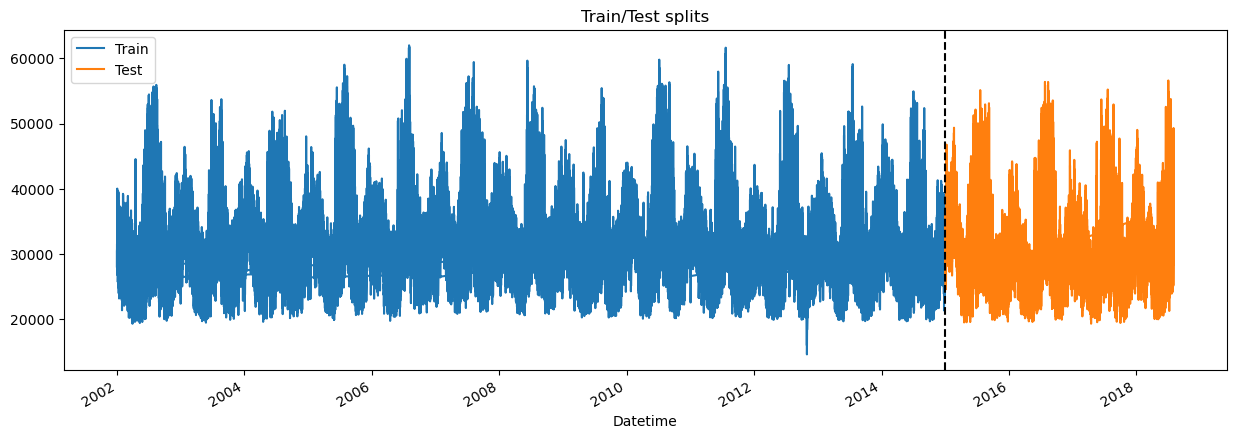

In [22]:
fig,ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax,label = 'Training',title = 'Train/Test splits')
test.plot(ax = ax,label = 'Testing')
ax.axvline('01-01-2015',color = 'black',ls = '--')
ax.legend(['Train','Test'])
plt.show()

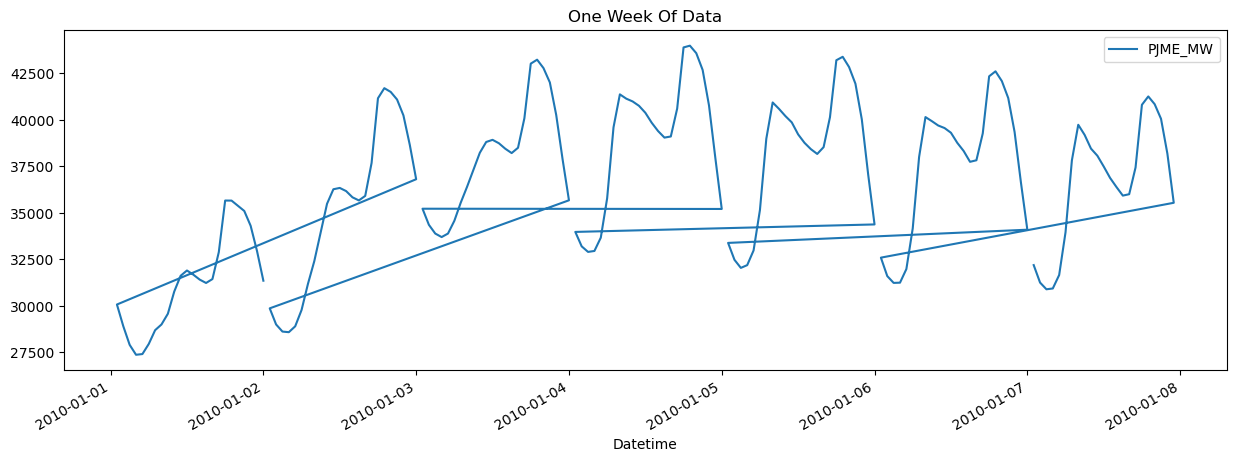

In [23]:
df.loc[(df.index > '01-01-2010')&(df.index < '01-08-2010')].plot(figsize = (15,5),
                                                                title = 'One Week Of Data')
plt.show()

## Feature engineering



In [25]:
df.index.hour

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
      dtype='int32', name='Datetime', length=145366)

In [26]:
df.index.day_of_week  # monday = 0 - sunday = 6

Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       ...
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype='int32', name='Datetime', length=145366)

In [27]:
df.index.quarter

Index([4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       ...
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype='int32', name='Datetime', length=145366)

In [28]:
df.index.month

Index([12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       ...
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype='int32', name='Datetime', length=145366)

In [29]:
df.index.year

Index([2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002,
       ...
       2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018],
      dtype='int32', name='Datetime', length=145366)

In [30]:
df.index.dayofyear

Index([365, 365, 365, 365, 365, 365, 365, 365, 365, 365,
       ...
         1,   1,   1,   1,   1,   1,   1,   1,   1,   2],
      dtype='int32', name='Datetime', length=145366)

In [31]:
df.index.day

Index([31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       ...
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2],
      dtype='int32', name='Datetime', length=145366)

In [32]:
def feature_creation(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

In [33]:
df = feature_creation(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31


## Feature Target Relationship Pattern

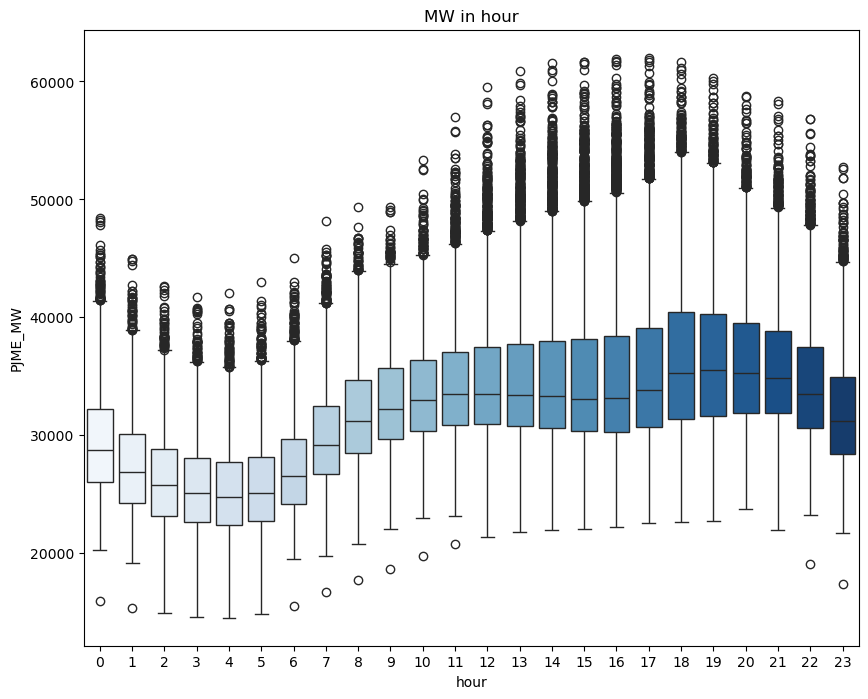

In [35]:
fig,ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df,x = 'hour',y = 'PJME_MW',palette='Blues')
ax.set_title('MW in hour')
plt.show()

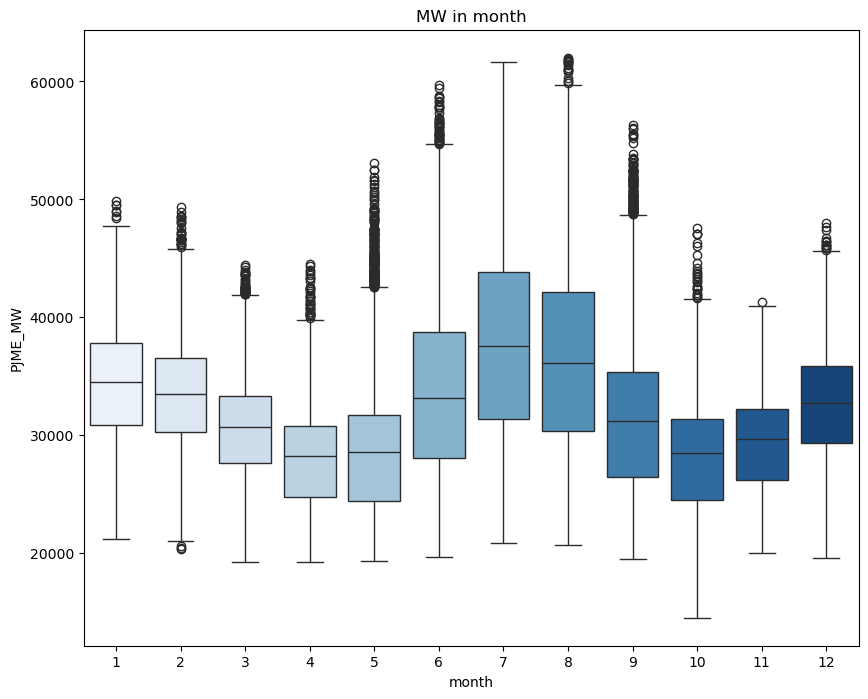

In [36]:
fig,ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df,x = 'month',y = 'PJME_MW',palette='Blues')
ax.set_title('MW in month')
plt.show()

## Model initialization


In [38]:
train = feature_creation(train)
train.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31


In [39]:
test = feature_creation(test)
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31


In [40]:
FEATURES = ['hour','dayofweek','quarter','month','year','dayofyear']
TARGET = 'PJME_MW'

In [41]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

## Model Training


In [43]:
reg = xgb.XGBRegressor(n_estimators = 1000,early_stopping_rounds = 50,learning_rate = 0.01)
reg.fit(x_train,y_train,eval_set = [(x_train,y_train),(x_test,y_test)],
       verbose = 100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


## Feature Importance

In [45]:
reg.feature_names_in_

array(['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'],
      dtype='<U9')

In [46]:
f1 = pd.DataFrame(data = reg.feature_importances_,index = reg.feature_names_in_,columns = ['Importance'])
f1

,Importance
hour,0.463878
dayofweek,0.162005
quarter,0.028881
month,0.203161
year,0.023824
dayofyear,0.118251


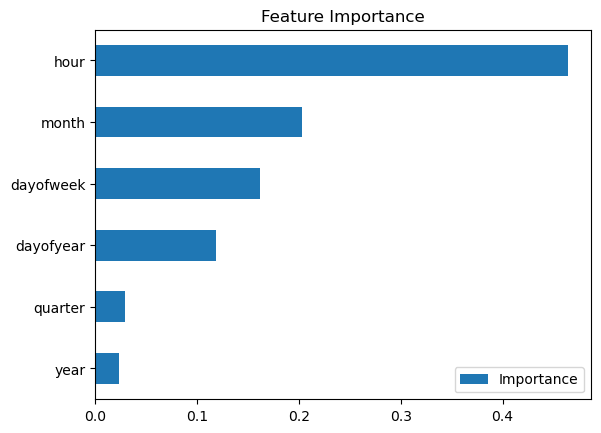

In [47]:
f1.sort_values('Importance').plot(kind = 'barh',title = 'Feature Importance')
plt.show()

## Forecast on Test

In [49]:
reg.predict(x_test)

array([32393.352, 29040.168, 27877.018, ..., 36229.527, 35141.754,
       32339.713], dtype=float32)

In [50]:
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31


In [51]:
test['prediction'] = reg.predict(x_test)
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,prediction
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,32393.351562
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,29040.167969
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,27877.017578
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,27576.720703
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,27576.720703


In [52]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31


In [53]:
df = df.merge(test[['prediction']],how = 'left',left_index = True,right_index = True)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,prediction
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,NaN
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,38623.246094
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,38495.484375
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,36229.527344


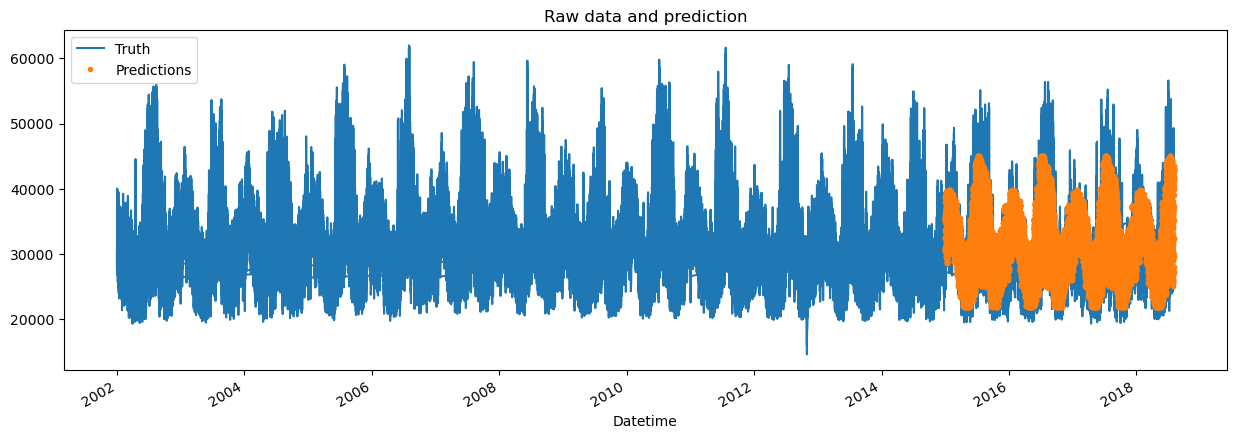

In [54]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['prediction'].plot(ax=ax,style = '.')
ax.set_title('Raw data and prediction')
plt.legend(['Truth','Predictions'])
plt.show()

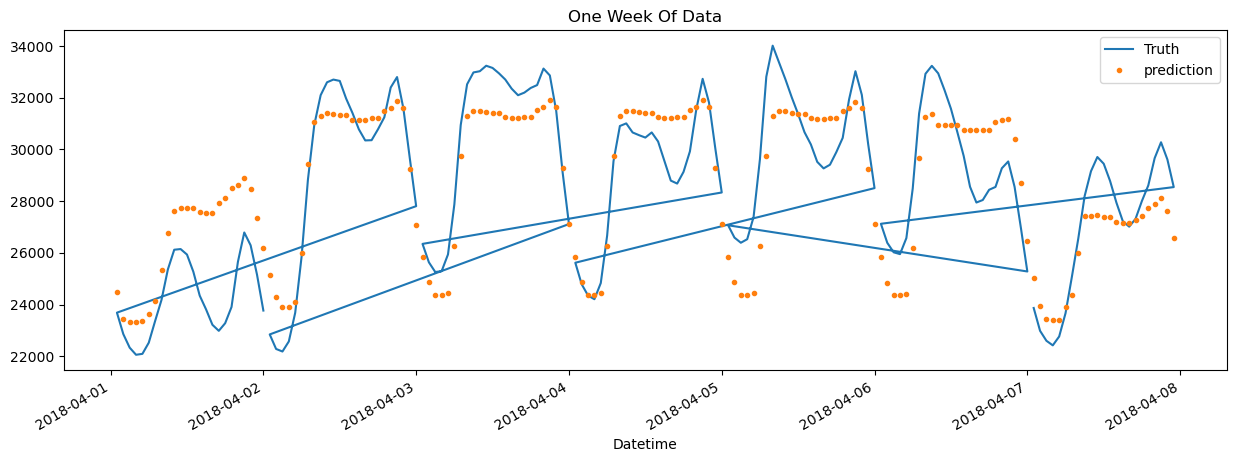

In [55]:
ax = df.loc[(df.index > '04-01-2018')&(df.index < '04-08-2018')]['PJME_MW'].plot(figsize = (15,5),
                                                                title = 'One Week Of Data')
df.loc[(df.index > '04-01-2018')&(df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth','prediction'])
plt.show()

## Hyper parameter tuning



## Performance checking


In [58]:
np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))

3741.030178837441

## Error Calculation

In [60]:
test['error']= np.abs(test[TARGET]-test['prediction'])

In [61]:
test.index.date

array([datetime.date(2015, 1, 1), datetime.date(2015, 12, 31),
       datetime.date(2015, 12, 31), ..., datetime.date(2018, 1, 1),
       datetime.date(2018, 1, 1), datetime.date(2018, 1, 2)], dtype=object)

In [62]:
test['date'] = test.index.date

In [63]:
test.groupby(['date'])['error'].mean().sort_values(ascending = False).head(10)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
2018-01-06    10407.698161
2015-02-20    10143.611491
2017-05-19     9495.122640
2016-07-04     9440.610596
2016-07-23     9362.332682
Name: error, dtype: float64

In [64]:
test.groupby(['date'])['error'].mean().sort_values(ascending = True).head(10)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
2015-10-28    459.086426
2016-06-03    467.453532
2018-02-06    477.327718
2016-08-08    496.441406
2016-12-12    553.641357
Name: error, dtype: float64

## Result


FROM THE ABOVE PROGRAM WE CAN SEE THAT THE MODEL IS BAD AT PREDICTING THE OUTPUT 'PJME_MW'.. SO WE NEED TO DO SOME PROCESS TO MAKE ITS PERFORMANCE BETTER THAN BEFORE

# Further Analysis


In [68]:
dt = pd.read_csv('./DATA/PJME_hourly.csv')
dt = dt.set_index('Datetime')
dt.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [69]:
dt.index = pd.to_datetime(dt.index)

In [70]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


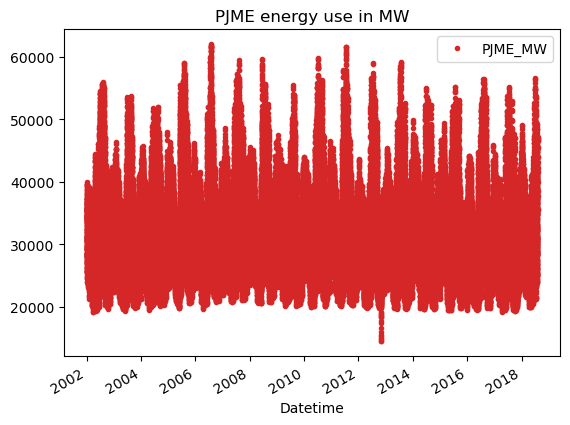

In [71]:
dt.plot(style = '.',color = col_pal[3],title = 'PJME energy use in MW')
plt.show()

## Outlier Removal

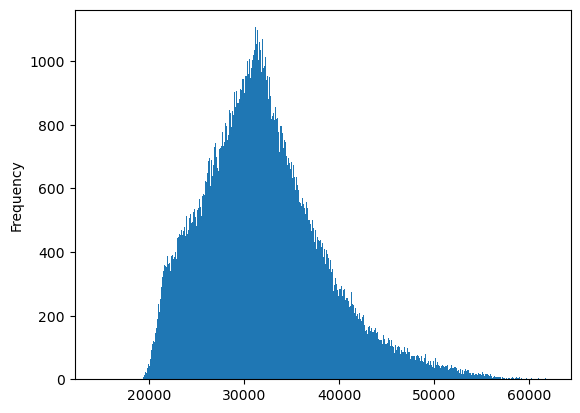

In [73]:
dt['PJME_MW'].plot(kind = 'hist',bins = 500)
plt.show()

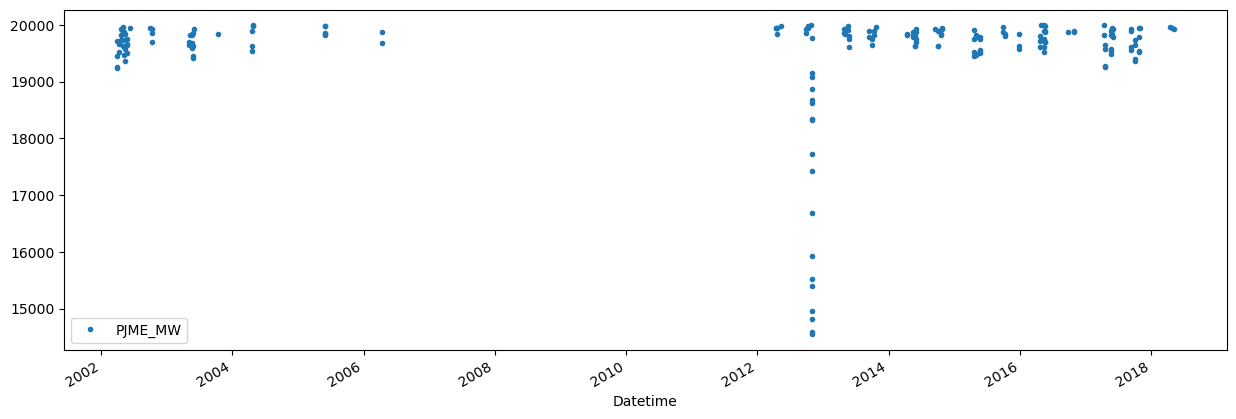

In [74]:
dt.query('PJME_MW < 20000').plot(figsize = (15,5),style = '.')
plt.show()

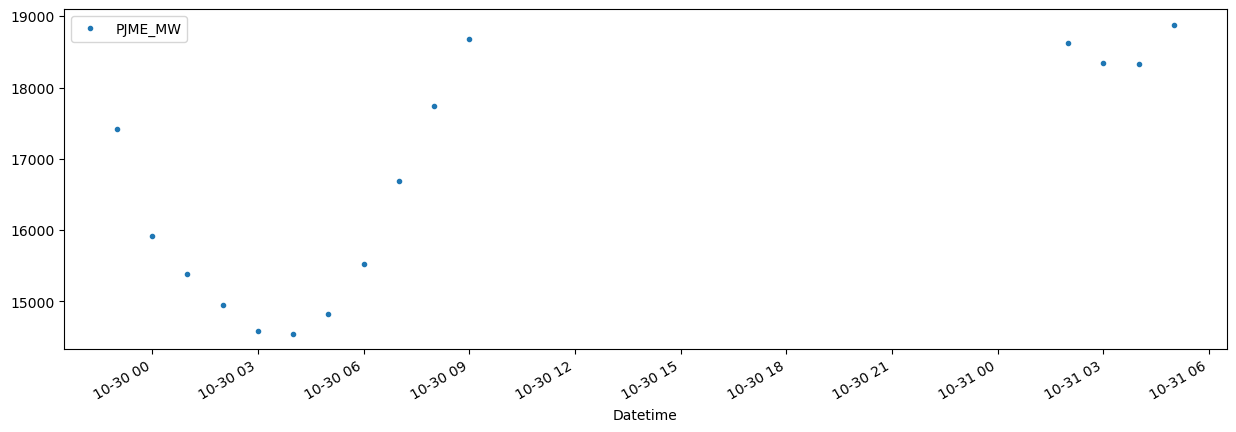

In [75]:
dt.query('PJME_MW < 19000').plot(figsize = (15,5),style = '.')
plt.show()

In [76]:
dt = dt.query('PJME_MW > 19000').copy()

In [77]:
dt.shape

(145351, 1)

WE REMOVED 15 DATA POINTS

## Examine Train and Test Split

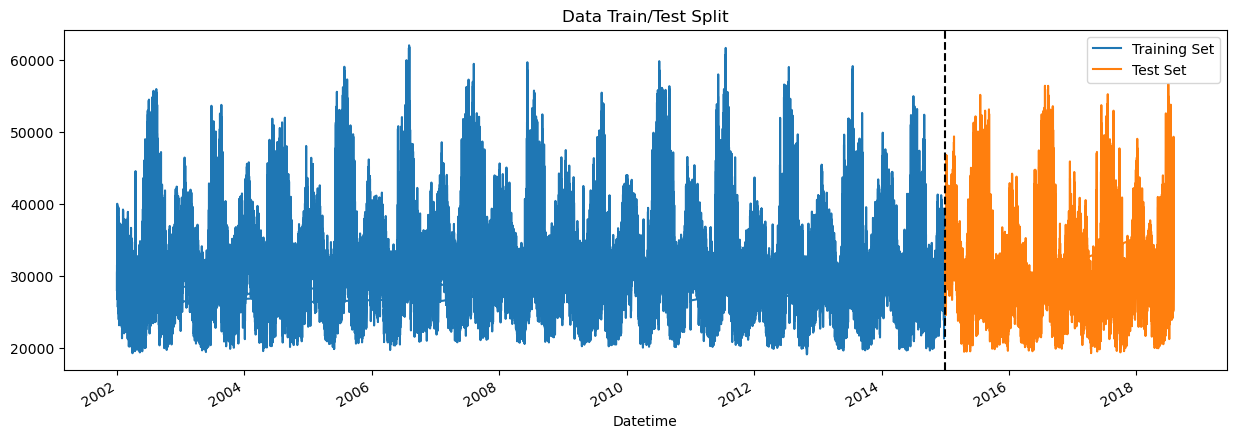

In [80]:
train = dt.loc[dt.index < '01-01-2015']
test = dt.loc[dt.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Time Series Cross Validation

In [82]:
tss = TimeSeriesSplit(n_splits= 5, test_size = 24*365*1,gap = 24)
dt = dt.sort_index()
# fixing test_size as 1 yr = 24 hrs , 365 days, 1 yr

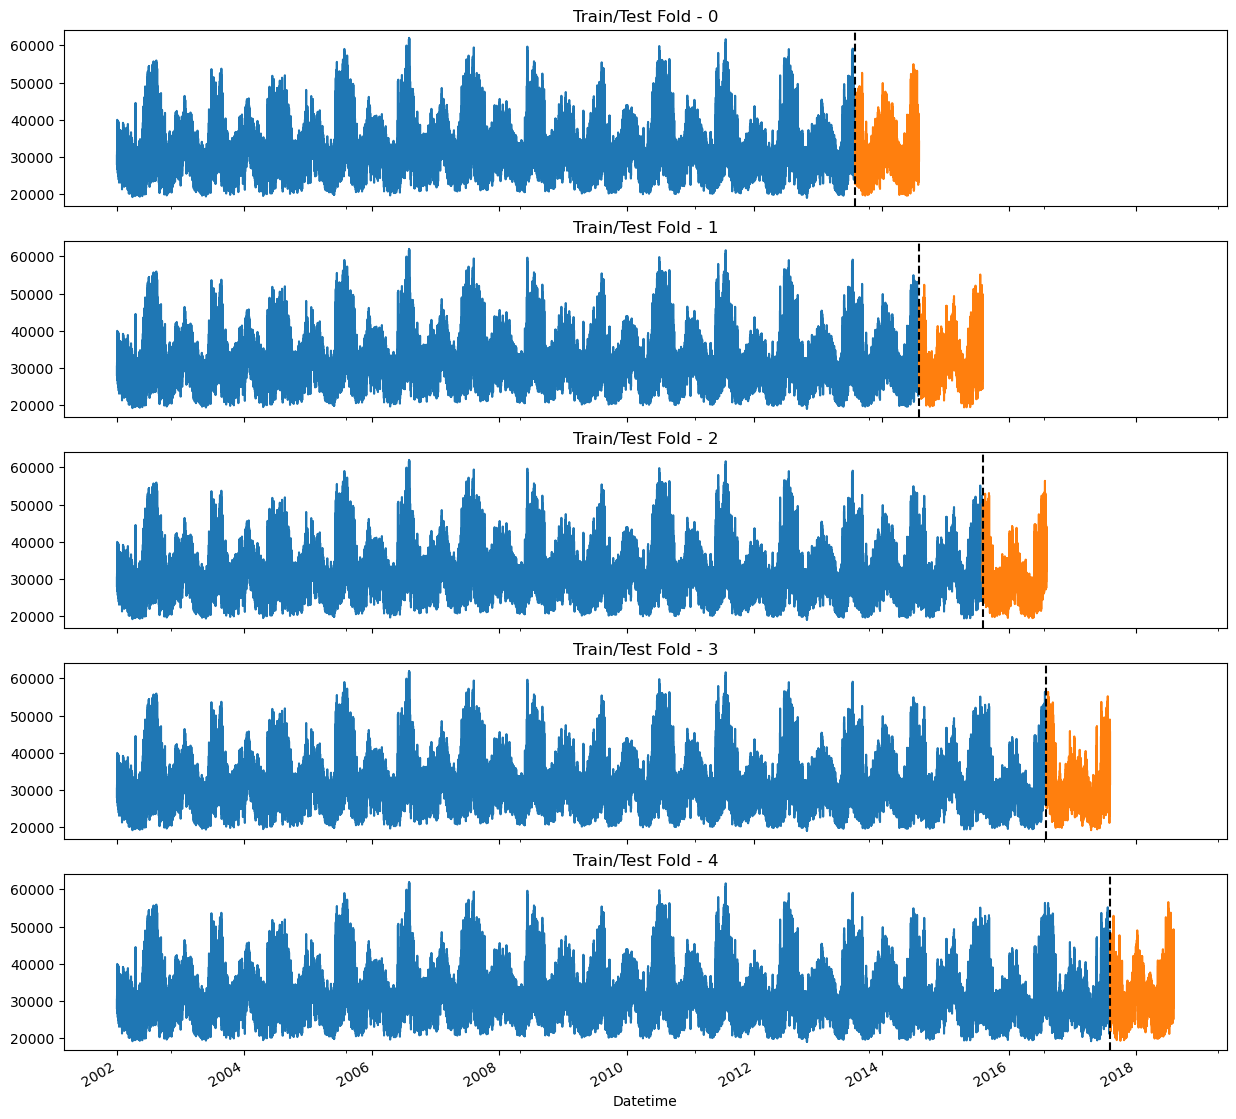

In [83]:
fig,axs = plt.subplots(5, 1, figsize = (15,15),sharex = True)

fold = 0
for train_idx,val_idx in tss.split(dt):
    train = dt.iloc[train_idx]
    test = dt.iloc[val_idx]
    train['PJME_MW'].plot(ax = axs[fold],label = 'Training set',
                         title = f'Train/Test Fold - {fold}')
    test['PJME_MW'].plot(ax=axs[fold],label = 'Test set')
    axs[fold].axvline(test.index.min(),color = 'black',ls = '--')
    fold+=1

## Forecast Horizon

In [85]:
dt.index.isocalendar().week

Datetime
2002-01-01 01:00:00     1
2002-01-01 02:00:00     1
2002-01-01 03:00:00     1
2002-01-01 04:00:00     1
2002-01-01 05:00:00     1
                       ..
2018-08-02 20:00:00    31
2018-08-02 21:00:00    31
2018-08-02 22:00:00    31
2018-08-02 23:00:00    31
2018-08-03 00:00:00    31
Name: week, Length: 145351, dtype: UInt32

In [86]:
def create_features_p2(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

dt = create_features_p2(dt)

In [87]:
dt.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1


### Lag Feature

What was the target (x) days in the past ie) to use the target value for that many days in the past as a new feature 

In [90]:
target_map = dt['PJME_MW'].to_dict()

In [91]:
target_map

{Timestamp('2002-01-01 01:00:00'): 30393.0,
 Timestamp('2002-01-01 02:00:00'): 29265.0,
 Timestamp('2002-01-01 03:00:00'): 28357.0,
 Timestamp('2002-01-01 04:00:00'): 27899.0,
 Timestamp('2002-01-01 05:00:00'): 28057.0,
 Timestamp('2002-01-01 06:00:00'): 28654.0,
 Timestamp('2002-01-01 07:00:00'): 29308.0,
 Timestamp('2002-01-01 08:00:00'): 29595.0,
 Timestamp('2002-01-01 09:00:00'): 29943.0,
 Timestamp('2002-01-01 10:00:00'): 30692.0,
 Timestamp('2002-01-01 11:00:00'): 31395.0,
 Timestamp('2002-01-01 12:00:00'): 31496.0,
 Timestamp('2002-01-01 13:00:00'): 31031.0,
 Timestamp('2002-01-01 14:00:00'): 30360.0,
 Timestamp('2002-01-01 15:00:00'): 29798.0,
 Timestamp('2002-01-01 16:00:00'): 29720.0,
 Timestamp('2002-01-01 17:00:00'): 31271.0,
 Timestamp('2002-01-01 18:00:00'): 35103.0,
 Timestamp('2002-01-01 19:00:00'): 35732.0,
 Timestamp('2002-01-01 20:00:00'): 35639.0,
 Timestamp('2002-01-01 21:00:00'): 35285.0,
 Timestamp('2002-01-01 22:00:00'): 34007.0,
 Timestamp('2002-01-01 23:00:00'

In [92]:
(dt.index - pd.Timedelta('364 days')).map(target_map)

Index([    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,
       ...
       46462.0, 47318.0, 47490.0, 46436.0, 44429.0, 42256.0, 41210.0, 39525.0,
       36490.0, 33539.0],
      dtype='float64', name='Datetime', length=145351)

In [93]:
def add_lags(dt):
    target_map = dt['PJME_MW'].to_dict()
    dt['lag1'] = (dt.index - pd.Timedelta('364 days')).map(target_map)
    dt['lag2'] = (dt.index - pd.Timedelta('728 days')).map(target_map)
    dt['lag3'] = (dt.index - pd.Timedelta('1092 days')).map(target_map)
    return dt

In [94]:
dt  = add_lags(dt)

In [95]:
dt.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN


In [96]:
dt.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


## Train Using Cross Validation

In [98]:
tss = TimeSeriesSplit(n_splits = 5,test_size=24*365*1, gap=24)
dt = dt.sort_index()

fold = 0
preds = []
scores = []

for train_idx,val_idx in tss.split(dt):
    train = dt.iloc[train_idx]
    test = dt.iloc[val_idx]

    train = create_features_p2(train)
    test = create_features_p2(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    x_train = train[FEATURES]
    x_test = test[FEATURES]
    y_train = train[TARGET]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(x_train,y_train,eval_set = [(x_train,y_train),(x_test,y_test)],verbose = 100)
    y_pred = reg.predict(x_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163
[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[441]	validation_0-rmse:3370.76149	validation_1-rmse:3764.48078
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241
[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	v

In [99]:
print(f'scores across 5 folds {np.mean(scores):0.2f}')
print(f'Scores of 5 folds {scores}')

scores across 5 folds 3742.58
Scores of 5 folds [3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


## Creating The Future Dataframe

In [101]:
# Retrain all the data
dt = create_features_p2(dt)
F = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
T = 'PJME_MW'

x_all = dt[F]
y_all = dt[T]

reg_re = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
reg_re.fit(x_all,y_all,eval_set = [(x_all,y_all)],verbose = 100)


[0]	validation_0-rmse:32403.88991
[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[500]	validation_0-rmse:3456.23244
[600]	validation_0-rmse:3401.28695
[700]	validation_0-rmse:3365.32547
[800]	validation_0-rmse:3334.20660
[900]	validation_0-rmse:3307.11413
[999]	validation_0-rmse:3284.26319


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [176]:
# Creating date dataframe to predict

dt.index.max()

Timestamp('2018-08-03 00:00:00')

In [180]:
pd.date_range('2018-08-03','2019-08-01',freq = '1h')

DatetimeIndex(['2018-08-03 00:00:00', '2018-08-03 01:00:00',
               '2018-08-03 02:00:00', '2018-08-03 03:00:00',
               '2018-08-03 04:00:00', '2018-08-03 05:00:00',
               '2018-08-03 06:00:00', '2018-08-03 07:00:00',
               '2018-08-03 08:00:00', '2018-08-03 09:00:00',
               ...
               '2019-07-31 15:00:00', '2019-07-31 16:00:00',
               '2019-07-31 17:00:00', '2019-07-31 18:00:00',
               '2019-07-31 19:00:00', '2019-07-31 20:00:00',
               '2019-07-31 21:00:00', '2019-07-31 22:00:00',
               '2019-07-31 23:00:00', '2019-08-01 00:00:00'],
              dtype='datetime64[ns]', length=8713, freq='h')

In [184]:
future = pd.date_range('2018-08-03','2019-08-01',freq = '1h')
future_df = pd.DataFrame(index = future)
future_df['isfuture'] = True
dt['isfuture'] = False
df_end = pd.concat([dt,future_df])
df_end = create_features_p2(df_end)
df_end = add_lags(df_end)

In [186]:
fea_fut = df_end.query('isfuture').copy()

In [188]:
fea_fut

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isfuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


## Predicting The Future

In [192]:
fea_fut['prediction'] = reg_re.predict(fea_fut[F])

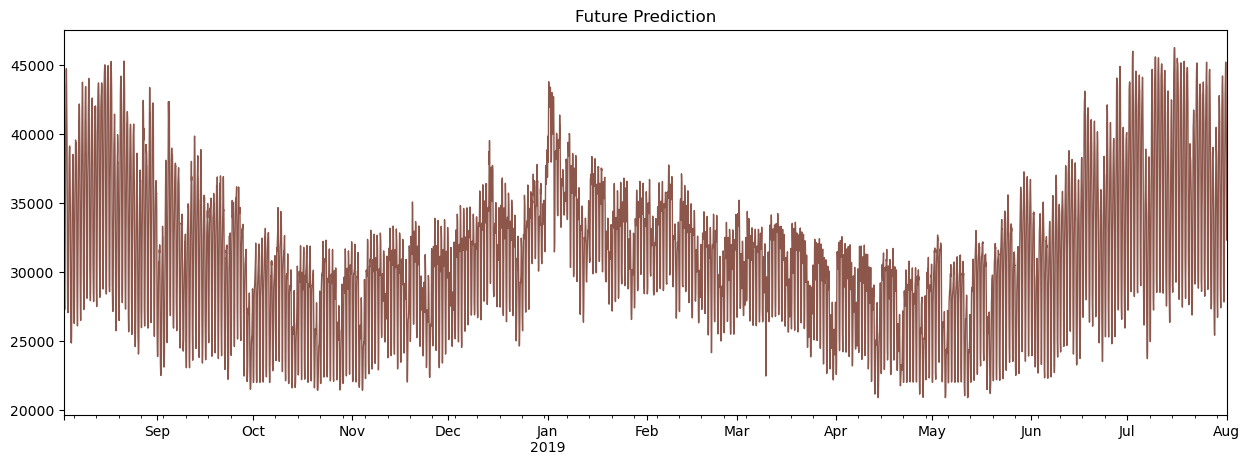

In [194]:
fea_fut['prediction'].plot(figsize = (15,5),color = col_pal[5],ms = 1,lw=1,
                          title = 'Future Prediction')
plt.show()

THIS IS THE PREDICTION FOR NEXT 1 YEAR